参考文章：https://blog.csdn.net/qq_29931565/article/details/119395353

实时检测棋盘格相对于摄像头的距离以及位姿。为此主要步骤可分为以下三个步骤：标定图片的拍摄、相机的标定、以及棋盘格位姿的实时解算。

## 1.标定图片的拍摄

In [ ]:

import cv2
camera = cv2.VideoCapture(0)
i = 1
while i < 50:
    _, frame = camera.read()
    cv2.imwrite("E:\OneDrive\AiLearning\myPointCalibration\cali2"+str(i)+'.jpg', frame, [int(cv2.IMWRITE_PNG_COMPRESSION), 0]) 
    cv2.imshow('frame', frame)
    i += 1
    if cv2.waitKey(200) & 0xFF == 27: # 按ESC键退出
        break

cv2.destroyAllWindows()

## 2.单目相机的标定

In [2]:
import numpy as np
import cv2
import glob

# 准备标定板上角点的物理坐标，假设标定板正好在世界坐标系的原点，
# 例如，使用一个标准的棋盘格标定板，每个格子的大小为square_size，
# 棋盘格的大小为 (width, height)。
square_size = 2.0  # 实际测量的格子大小
width, height = 11, 8  # 内角点的数量
objp = np.zeros((width*height, 3), np.float32)
# 将世界坐标系建在标定板上，所有点的Z坐标全部为0，所以只需要赋值x和y
objp[:,:2] = np.mgrid[0:width,0:height].T.reshape(-1,2) * square_size

# 保存角点的数组
objpoints = [] # 3d point in real world space
imgpoints = [] # 2d points in image plane.

# 读取图像文件

images = glob.glob('dataset36/right/*.bmp')

criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 0.001)

for fname in images:
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # 查找棋盘格角点
    ret, corners = cv2.findChessboardCorners(gray, (width,height), None)

    # 如果找到了，添加物理坐标和图像坐标
    if ret == True:
        objpoints.append(objp) #物理坐标的z都为0
        corners2 = cv2.cornerSubPix(gray,corners, (11,11), (-1,-1), criteria)
        imgpoints.append(corners2)

        # 可以选择绘制并显示角点
        cv2.drawChessboardCorners(img, (width,height), corners2, ret)
        cv2.imshow('img', img)
        cv2.waitKey(300)

cv2.destroyAllWindows()

# 标定
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)

print("Camera matrix : \n")
print(mtx)
print("dist : \n")
print(dist)
print("rvecs : \n")
print(rvecs)
print("tvecs : \n")
print(tvecs)

#内参数矩阵
Camera_intrincsic = {"mtx": mtx, "dist": dist}

# 保存内参矩阵和畸变系数到文件
np.savez('calibration_data_right.npz', mtx=mtx, dist=dist)

Camera matrix : 

[[4.74867594e+03 0.00000000e+00 1.23981465e+03]
 [0.00000000e+00 4.74786123e+03 1.02212354e+03]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00]]
dist : 

[[-3.89374928e-02  6.43430868e-01  9.76020874e-04 -1.28133263e-04
  -2.80602130e+00]]
rvecs : 

(array([[-0.69032699],
       [ 0.53888694],
       [ 1.08337324]]), array([[-0.19306631],
       [ 0.22337374],
       [-1.82141439]]), array([[-0.12293013],
       [-0.46200124],
       [-2.09808073]]), array([[ 0.00532759],
       [-0.21614954],
       [-2.05278969]]), array([[-0.43263053],
       [-0.07536704],
       [ 0.89113357]]), array([[-0.24607048],
       [-0.43580022],
       [-0.99648016]]), array([[-0.15045836],
       [ 0.07057471],
       [ 0.81791949]]), array([[-0.02970309],
       [ 0.20559332],
       [ 1.76316918]]), array([[-0.23584504],
       [-0.12236644],
       [ 1.44725805]]), array([[-0.1531179 ],
       [ 0.17805078],
       [-1.87610869]]), array([[-0.37564779],
       [ 0.125205  ],
       

后面解算位姿所需要的参数为内参数矩阵mtx和畸变系数dist。据此求得的内参数矩阵和畸变系数如下：
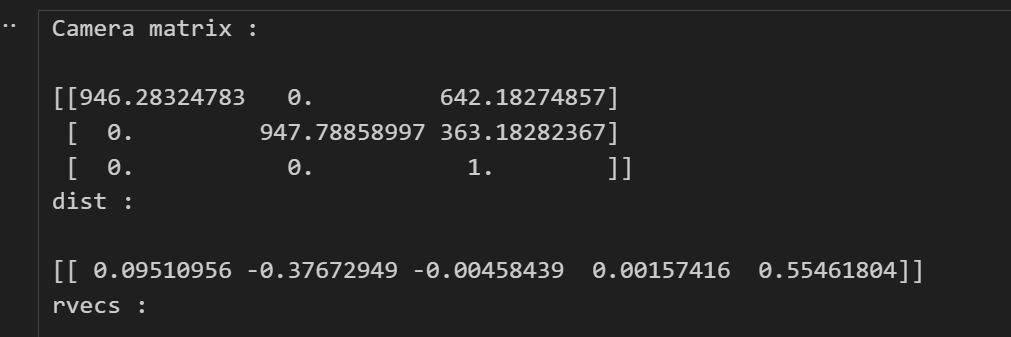
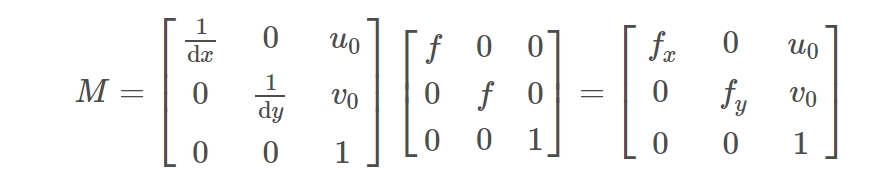



dx和dy分别是每个像素在图像平面x和y的物理尺寸，(u0,v0)是图像坐标系原点在像素坐标系下的坐标，f为摄像头的焦距，fx与fy为焦距f与像素物理尺寸的比值，单位为个（像素数目）

## 3. 棋盘格位姿的实时解算(可跳过)

利用solvePnP函数可以实时解算出每一帧的旋转矢量rvec和平移矢量tvec。旋转矢量虽然简洁，但是作为结果显示不够直观，故需要将其转换为欧拉角。

        在欧拉角中，俯仰角（pitch）代表绕x轴旋转的角度， 偏航角（yaw）代表绕y轴旋转的角度，滚转角（roll）代表绕z轴旋转的角度。其中，默认逆时针选择为正，顺时针旋转为负。

In [ ]:
import math
obj_points = objp #存储3D点
img_points = []

camera = cv2.VideoCapture(0)

while True:
    _,frame = camera.read()
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    size = gray.shape[::-1]
    ret, corners = cv2.findChessboardCorners(gray, (width,height), None)
    if ret:
        #是使用NumPy库将corners列表（或任何可迭代对象）转换为NumPy数组的过程
        img_points = np.array(corners)
        cv2.drawChessboardCorners(frame, (width,height),corners,ret)
        
        # rvec: 旋转向量 tvec: 平移向量
        _,rvec,tvec = cv2.solvePnP(obj_points, img_points, Camera_intrincsic["mtx"], Camera_intrincsic["dist"]) #解算位姿
        distance = math.sqrt(tvec[0]**2 + tvec[1]**2 + tvec[2]** 2) #计算距离
        rvec_matrix = cv2.Rodrigues(rvec)[0]  # 旋转向量->旋转矩阵
        # 通过将rvec_matrix和tvec水平堆叠，我们得到了一个3x4的矩阵，它将旋转和平移组合在一起，形成了一个完整的刚体变换矩阵或投影矩阵。这个矩阵可以用于将三维点从一个坐标系转换到另一个坐标系
        proj_matrix = np.hstack((rvec_matrix, tvec)) #用于水平（按列顺序）堆叠数组。它接收一个元组或列表作为输入，其中包含要堆叠的数组。
        eulerAngels = cv2.decomposeProjectionMatrix(proj_matrix)[6] #欧拉角
        pitch ,yaw, roll = eulerAngels[0], eulerAngels[1] ,eulerAngels[2]
        cv2.putText(frame, "dist: %.2fcm, yaw: %.2f, pitch: %.2f, roll: %.2f" % (distance, yaw, pitch, roll), (10, frame.shape[0] - 20), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 255, 0), 2)
        cv2.imshow("frame", frame)
        if cv2.waitKey(1) & 0xFF == 27: #按esc退出
            break
    else:   # 画面中没有棋盘格
        cv2.putText(frame, "Unable to Detect Chessboard", (20, frame.shape[0] - 20), cv2.FONT_HERSHEY_SIMPLEX, 1.3, (0, 0, 255), 3) 
        cv2.imshow('frame', frame)
        if cv2.waitKey(1) & 0xFF == 27: # 按ESC键退出
            break
cv2.destroyAllWindows()





cv2.Rodrigues函数实现了从旋转向量到旋转矩阵（以及反向转换）的Rodrigues变换。这个转换允许在这两种旋转表示之间相互转换。

rvec_matrix = cv2.Rodrigues(rvec)[0]
rvec：输入的旋转向量，通常是通过解算相机的位姿得到的，比如使用cv2.solvePnP函数时得到的。
cv2.Rodrigues(rvec)：调用Rodrigues函数进行转换。这个函数返回一个元组，其中第一个元素是转换后的旋转矩阵。
[0]：从返回的元组中取出旋转矩阵。cv2.Rodrigues(rvec)实际上返回两个值：转换后的旋转矩阵和一个雅可比矩阵。在这里，我们只关心旋转矩阵，所以使用[0]来获取它。

decomposeProjectionMatrix函数可以从这样的矩阵中提取出相机的内参矩阵、旋转矩阵、平移向量以及欧拉角。

函数原型

retval, cameraMatrix, rotMatrix, transVect, rotMatrixX, rotMatrixY, rotMatrixZ, eulerAngles = cv2.decomposeProjectionMatrix(projMatrix)
projMatrix: 输入的3x4投影矩阵。
retval: 函数调用的返回值。
cameraMatrix: 相机的内参矩阵。
rotMatrix: 从投影矩阵中提取的3x3旋转矩阵。
transVect: 从投影矩阵中提取的平移向量。
rotMatrixX, rotMatrixY, rotMatrixZ: 分别代表绕x轴、y轴和z轴旋转的矩阵。
eulerAngles: 从旋转矩阵中提取的欧拉角，以度为单位。

In [ ]:
calibration_right_data = np.load('calibration_data_right.npz')
mtx_right_loaded = calibration_right_data['mtx']
dist_right_loaded = calibration_right_data['dist']
print("Camera matrix : \n")
print(mtx_right_loaded)
print("dist : \n")
print(dist_right_loaded)

## 4.双目标定

In [4]:
import numpy as np
import cv2
import glob
import math

#设置标定版参数
square_size = 2.0
pattern_size = (11, 8)
# np.prod(pattern_size)计算pattern_size中所有元素的乘积，即棋盘格内角点的总数（在这个例子中是54），3表示三维空间中的坐标（X, Y, Z）。
# np.float32指定了数组的数据类型为32位浮点数。
pattern_points = np.zeros((np.prod(pattern_size), 3), np.float32)
# 为棋盘格的每个内角点生成一个三维世界坐标系中的位置，其中Z坐标默认为0（因为假设棋盘格平放在XY平面上）。
pattern_points[:, :2] = np.mgrid[0:pattern_size[0], 0:pattern_size[1]].T.reshape(-1, 2)
pattern_points *= square_size

# mtx_left_loaded = np.array([[4.75264855e+03, 0.00000000e+00, 1.29080096e+03],
#  [0.00000000e+00, 4.75252296e+03, 1.01682863e+03],
#  [0.00000000e+00, 0.00000000e+00, 1.00000000e+00]])
# dist_left_loaded = np.array([[-8.56442070e-03, -2.95830396e-01, -4.96994179e-04, -1.91385150e-04, 6.89369709e+00]])

# mtx_right_loaded = np.array([[4.73199401e+03, 0.00000000e+00, 1.25612416e+03],
#  [0.00000000e+00, 4.73199806e+03, 1.05937725e+03],
#  [0.00000000e+00, 0.00000000e+00, 1.00000000e+00]])
# dist_right_loaded = np.array([[-2.57534938e-02,  3.08796286e-01,  3.83915597e-04,  1.00553239e-03, 8.11122867e-01]])
# 读取内参矩阵和畸变系数
calibration_left_data = np.load('calibration_data_left.npz')
mtx_left_loaded = calibration_left_data['mtx']
dist_left_loaded = calibration_left_data['dist']

calibration_right_data = np.load('calibration_data_right.npz')
mtx_right_loaded = calibration_right_data['mtx']
dist_right_loaded = calibration_right_data['dist']

#准备对象点和图像点的存储列表
obj_points = []
img_points_left = []
img_points_right = []

#加载左右相机的图像
images_left = glob.glob('dataset36/left/*.bmp')
images_right = glob.glob('dataset36/right/*.bmp')


for img_left_path, img_right_path in zip(images_left, images_right):#表示对images_left和images_right两个列表进行遍历，同时取出对应位置上的元素img_left_path和img_right_path。
    img_left = cv2.imread(img_left_path, cv2.IMREAD_GRAYSCALE)
    img_right=  cv2.imread(img_right_path, cv2.IMREAD_GRAYSCALE)
    # cv2.imshow('img', img_left)
    # cv2.waitKey(300)
    
    # 在左右图像中查找角点
    found_left, corners_left = cv2.findChessboardCorners(img_left, pattern_size)
    found_right, corners_right = cv2.findChessboardCorners(img_right, pattern_size)

    if found_left and found_right:
        # 优化角点位置
        term = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_COUNT, 30, 0.1)
        cv2.cornerSubPix(img_left, corners_left, (5, 5), (-1, -1), term)
        cv2.cornerSubPix(img_right, corners_right, (5, 5), (-1, -1), term)

        img_points_left.append(corners_left.reshape(-1, 2))
        img_points_right.append(corners_right.reshape(-1, 2))
        obj_points.append(pattern_points)

# 进行立体标定，计算两个相机之间的相对位置（外参）和各自的内参（焦距、主点位置、畸变系数等）。
ret, mtx_left, dist_left, mtx_right, dist_right, R, T, E, F = cv2.stereoCalibrate(
    obj_points, img_points_left, img_points_right, mtx_left_loaded, dist_left_loaded, mtx_right_loaded, dist_right_loaded, img_left.shape[::-1],
    flags=cv2.CALIB_FIX_INTRINSIC, criteria=(cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 100, 1e-5))

print("左相机内参:\n", mtx_left)
print("右相机内参:\n", mtx_right)
print("旋转矩阵:\n", R)
print("平移向量:\n", T)

distance = math.sqrt(T[0]**2 + T[1]**2 + T[2]** 2) #计算距离
print("光心之间的距离为：", distance, "cm")
# distance2 = np.linalg.norm(T)
# print("光心之间的距离2为：", distance2, "cm")

np.savez("stereocali.npz", R=R, T=T)
cv2.destroyAllWindows()


左相机内参:
 [[4.71512516e+03 0.00000000e+00 1.23338188e+03]
 [0.00000000e+00 4.71383218e+03 1.03916322e+03]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00]]
右相机内参:
 [[4.74867594e+03 0.00000000e+00 1.23981465e+03]
 [0.00000000e+00 4.74786123e+03 1.02212354e+03]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00]]
旋转矩阵:
 [[ 0.99978376  0.00708975 -0.01954911]
 [ 0.00304579  0.88002333  0.47492069]
 [ 0.02057075 -0.47487754  0.87981144]]
平移向量:
 [[ -0.1759027 ]
 [-47.68093605]
 [ 11.92470327]]
光心之间的距离为： 49.1497828292489 cm


/tmp/ipykernel_167398/277861657.py:74: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  distance = math.sqrt(T[0]**2 + T[1]**2 + T[2]** 2) #计算距离


函数原型
cv2.stereoCalibrate()函数的基本原型如下：

python
Copy code
cv2.stereoCalibrate(objectPoints, imagePoints1, imagePoints2, cameraMatrix1, distCoeffs1, cameraMatrix2, distCoeffs2, imageSize, R=None, T=None, E=None, F=None, flags=None, criteria=None)
参数解析
objectPoints (obj_points): 3D点的世界坐标。这些点是标定板上角点的已知坐标，对于所有图像都是相同的。

imagePoints1 (img_points_left): 第一个相机（左相机）图像上的2D点。这些点是标定板上角点在左相机图像中的像素坐标。

imagePoints2 (img_points_right): 第二个相机（右相机）图像上的2D点。这些点是标定板上角点在右相机图像中的像素坐标。

cameraMatrix1, cameraMatrix2: 输入的相机内参矩阵。在调用stereoCalibrate时，这些通常设置为None（如果使用CALIB_FIX_INTRINSIC标志），意味着函数将自动估计这些参数。

distCoeffs1, distCoeffs2: 输入的畸变系数向量。同样，在使用CALIB_FIX_INTRINSIC标志时，这些通常设置为None。

imageSize: 用于标定的图像的大小。通常取自标定图像的尺寸，例如img_left.shape[::-1]确保以(width, height)的格式提供尺寸。

R, T: 输出参数，分别为两个相机坐标系之间的旋转矩阵和平移向量。

E, F: 输出参数，分别为本征矩阵和基础矩阵，它们描述了两个视图之间的几何关系。

flags: 标定时使用的额外选项。在这个例子中，CALIB_FIX_INTRINSIC告诉函数保持内参和畸变系数不变，仅计算R、T、E、F。

criteria: 停止迭代的条件。在这个例子中，设置为当迭代次数达到100次或者算法的精度达到1e-5时停止。

函数作用
该函数计算了两个相机间的相对位置和方向（通过R和T），这对于后续的立体视觉任务（如三维重建或深度估计）至关重要。
通过精确计算每个相机的内参和畸变系数，以及两相机间的外参，可以进行高质量的图像校正和深度图生成。
本征矩阵（E）和基础矩阵（F）提供了两个视图之间的几何关系，有助于理解场景的三维结构和两个相机之间的相对运动。
结论
通过执行cv2.stereoCalibrate函数，我们能够获得一对相机系统的全面标定结果，包括内参、外参以及本征和基础矩阵，这为进一步的立体匹配和三维重建任务打下了坚实的基础。

## 5.双目立体校正

In [8]:
import numpy as np
import cv2
# 读取单目内参矩阵和畸变系数
calibration_left_data = np.load('calibration_data_left.npz')
mtx_left_loaded = calibration_left_data['mtx']
dist_left_loaded = calibration_left_data['dist']

calibration_right_data = np.load('calibration_data_right.npz')
mtx_right_loaded = calibration_right_data['mtx']
dist_right_loaded = calibration_right_data['dist']

stereocali_data = np.load('stereocali.npz')
R = stereocali_data['R']
T = stereocali_data['T']

#读取图像
image_size = (2448, 2048)
# 计算校正变换
R1, R2, P1, P2, Q, validPixROI1, validPixROI2 = cv2.stereoRectify(
    mtx_left_loaded, dist_left_loaded, mtx_right_loaded, dist_right_loaded, image_size, R, T,alpha=-1)

# 计算畸变校正和立体校正的映射矩阵
map1x, map1y = cv2.initUndistortRectifyMap(mtx_left_loaded, dist_left_loaded, R1, P1, image_size, cv2.CV_32FC1)
map2x, map2y = cv2.initUndistortRectifyMap(mtx_right_loaded, dist_right_loaded, R2, P2, image_size, cv2.CV_32FC1)

print("重投影矩阵Q:\n",Q)

left_img = cv2.imread("Image_84.bmp")
right_img = cv2.imread("Image_85.bmp")
if left_img is None:
    print("Error loading left image.")
if right_img is None:
    print("Error loading right image.")

#应用映射进行畸变校正和立体校正
rectified_left = cv2.remap(left_img, map1x, map1y, cv2.INTER_LINEAR)
rectified_right = cv2.remap(right_img, map2x, map2y, cv2.INTER_LINEAR)
cv2.imwrite("rl.bmp", rectified_left)
cv2.imwrite("rr.bmp", rectified_right)
concat = cv2.hconcat([rectified_left, rectified_right])

i = 0
while (i < 2048):
    cv2.line(concat, (0,i), (4894,i), (0, 255, 0))
    i += 100
cv2.imwrite('rectified.bmp',concat)


# 打印映射矩阵的形状和数据类型
print("R:",R, "T:",T)
print("map1x:", map1x)
print("map1x shape:", map1x.shape, "dtype:", map1x.dtype)
print("map1y shape:", map1y.shape, "dtype:", map1y.dtype)
print("map2x shape:", map2x.shape, "dtype:", map2x.dtype)
print("map2y shape:", map2y.shape, "dtype:", map2y.dtype)
# cv2.imshow('Original Left', left_img)
# cv2.imshow('Original Right', right_img)
# cv2.imshow('rectified left', rectified_left)
# cv2.imshow('rectified right', rectified_right)
# cv2.waitKey(0)
# cv2.destroyAllWindows()



重投影矩阵Q:
 [[ 1.00000000e+00  0.00000000e+00  0.00000000e+00 -1.23713110e+03]
 [ 0.00000000e+00  1.00000000e+00  0.00000000e+00 -1.01865156e+03]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  4.73190055e+03]
 [ 0.00000000e+00  0.00000000e+00  2.03459699e-02 -0.00000000e+00]]
R: [[ 0.99978376  0.00708975 -0.01954911]
 [ 0.00304579  0.88002333  0.47492069]
 [ 0.02057075 -0.47487754  0.87981144]] T: [[ -0.1759027 ]
 [-47.68093605]
 [ 11.92470327]]
map1x: [[ 364.41455   364.61145   364.81015  ... 2103.082    2103.1064
  2103.129   ]
 [ 363.3616    363.56042   363.76102  ... 2104.3193   2104.3462
  2104.3708  ]
 [ 362.3114    362.51212   362.71463  ... 2105.5537   2105.5828
  2105.6096  ]
 ...
 [  83.131424   84.09258    85.05379  ... 2461.5854   2462.5544
  2463.5234  ]
 [  83.1901     84.15122    85.11238  ... 2461.5261   2462.495
  2463.464   ]
 [  83.24879    84.20986    85.17098  ... 2461.4666   2462.4355
  2463.4045  ]]
map1x shape: (2048, 2448) dtype: float32
map1y shape: (2048, 24

`cv2.stereoRectify`函数是OpenCV库中用于双目立体校正的核心函数。它的目的是计算出立体校正所需的变换矩阵，以便将来自两个摄像头的图像重映射到同一平面上，确保同一物体在两个图像上的投影位于同一水平线上。这对于后续的立体匹配和深度估计至关重要。下面详细解释这个函数的参数和返回值：

### 参数

- **mtx_left_loaded** 和 **mtx_right_loaded**：这两个参数分别代表左右摄像机的内参矩阵。内参矩阵包含了摄像机的焦距和光心坐标。

- **dist_left_loaded** 和 **dist_right_loaded**：这两个参数分别代表左右摄像机的畸变系数。畸变系数用于描述和校正摄像机镜头产生的畸变，包括径向畸变和切向畸变。

- **image_size**：这是一个元组，指定了用于立体校正的图像的大小，格式为(width, height)。

- **R**：这是一个3x3矩阵，表示从左摄像机坐标系到右摄像机坐标系的旋转。

- **T**：这是一个向量，表示从左摄像机坐标系到右摄像机坐标系的平移。

- **alpha**：这个参数用于调整校正后图像的视野大小。`alpha=0`时，只有有效的像素会被显示（可能会导致图像某些部分被裁剪），而`alpha=1`时，会显示尽可能多的像素（可能会引入黑色的无效区域）。这允许用户在去除畸变与保留图像信息之间做出权衡。

### 返回值

- **R1** 和 **R2**：这两个矩阵分别代表左右摄像机进行立体校正所需的旋转矩阵。

- **P1** 和 **P2**：这两个矩阵分别代表左右摄像机进行立体校正后的投影矩阵。它们包含了摄像机的内参和立体校正后的图像的位置信息。

- **Q**：这是一个4x4的重投影矩阵，可用于将立体视觉的视差图转换为深度图。这对于3D重建特别有用。

- **validPixROI1** 和 **validPixROI2**：这两个参数分别表示在立体校正后的左右图像中，所有有效像素构成的区域。这可以用于裁剪图像，去除因校正而引入的黑色边框。

通过调用`cv2.stereoRectify`并使用返回的矩阵，可以对双目摄像机拍摄的图像进行校正，以便进行高质量的立体匹配和深度估计。这个函数是双目视觉应用中实现准确深度感知的关键步骤之一。

`cv2.initUndistortRectifyMap` 函数是OpenCV中用于计算图像畸变校正和立体校正映射的函数。这一步骤是双目立体视觉系统中立体校正过程的一部分，旨在创建一个映射（即，一个从输入图像到校正图像的像素位置映射），以便对图像进行重新采样，从而消除畸变并对齐视图，以便进行后续的立体匹配和深度估计。下面是对该函数参数和作用的具体分析：

### 函数原型
```python
cv2.initUndistortRectifyMap(cameraMatrix, distCoeffs, R, newCameraMatrix, size, m1type)
```

### 参数解释

- **cameraMatrix**：摄像机的内参矩阵。对于左摄像机和右摄像机分别使用其对应的内参矩阵（`mtx_left_loaded` 和 `mtx_right_loaded`）。这个矩阵包含了焦距和光心（主点）的信息。

- **distCoeffs**：摄像机的畸变系数。同样，对于左摄像机和右摄像机分别使用其对应的畸变系数（`dist_left_loaded` 和 `dist_right_loaded`）。这些系数用于描述摄像机镜头引起的径向和切向畸变。

- **R**：立体校正所需的旋转矩阵（`R1` 或 `R2`），由`cv2.stereoRectify`计算得到。这个矩阵用于调整图像的视角，使得两个摄像机的图像在水平方向上对齐。

- **newCameraMatrix**：校正后的新摄像机内参矩阵（`P1` 或 `P2`），同样由`cv2.stereoRectify`计算得到。这个矩阵包含了校正后的焦距和光心位置，可能与原始摄像机内参矩阵有所不同。

- **size**：图像的尺寸（宽度和高度），用于指定输出映射的大小。

- **m1type**：输出映射的类型。`cv2.CV_32FC1` 表示映射数组的数据类型为32位浮点数。这个类型决定了映射的精度和表达能力。

### 功能和作用

- 该函数计算了从畸变图像到校正图像的映射关系。这个映射关系以两个单独的映射矩阵（`map1x, map1y` 对于左摄像机，`map2x, map2y` 对于右摄像机）的形式给出，分别对应于水平和垂直方向的像素映射。

- 使用这些映射矩阵，可以通过`cv2.remap`函数将原始图像转换为校正后的图像，从而为立体匹配准备好准确对齐的图像对。

通过这种方式，`cv2.initUndistortRectifyMap` 提供了一种有效的方法来预处理双目摄像机的图像数据，消除畸变，对齐左右视图，从而提高立体匹配和深度估计的准确性和可靠性。

重投影矩阵 \(Q\) 在立体视觉系统中用于将图像从视差图转换到三维空间坐标系。这个矩阵是通过立体标定过程（如使用OpenCV的`cv2.stereoCalibrate()`）计算得出的。\(Q\) 矩阵通常具有以下形式：

\[
Q = \begin{pmatrix}
1 & 0 & 0 & -c_x \\
0 & 1 & 0 & -c_y \\
0 & 0 & 0 & f \\
0 & 0 & -\frac{1}{T_x} & \frac{(c_x - c_x')}{T_x}
\end{pmatrix}
\]

其中：

- \(c_x, c_y\) 是左相机图像的主点坐标。
- \(c_x'\) 是右相机图像的主点在左相机图像坐标系中的x坐标。
- \(f\) 是相机的焦距。
- \(T_x\) 是两个相机光心之间的水平距离（即基线长度）。

每个元素的含义如下：

- 第一行和第二行的 \(1\) 和 \(-c_x, -c_y\) 起到了将像素坐标平移到以左相机的主点为原点的坐标系中的作用。
- 第三行的 \(0\) 表明Y轴上的视差不影响深度的计算。
- 第三行的 \(f\) 是焦距，它与视差值相乘用于计算深度。
- 第四行的 \(-\frac{1}{T_x}\) 用于将视差值转换为深度值。因为深度 \(Z\) 与视差 \(d\) 成反比（\(Z = \frac{f \cdot T_x}{d}\)），这里的 \(-\frac{1}{T_x}\) 就是这个计算的一部分。
- 第四行的 \(\frac{(c_x - c_x')}{T_x}\) 是一个校正项，用于在计算深度时考虑两个相机主点坐标的差异。

使用 \(Q\) 矩阵，可以通过以下方式将视差图 \(d(u,v)\) 转换为三维点 \((X, Y, Z, W)\)：

\[
\begin{pmatrix}
X \\
Y \\
Z \\
W
\end{pmatrix}
= Q \cdot
\begin{pmatrix}
u \\
v \\
d(u,v) \\
1
\end{pmatrix}
\]

然后，通过将 \(X, Y, Z\) 除以 \(W\) 来获取归一化的三维坐标 \((X/W, Y/W, Z/W)\)。这样，就可以得到每个像素点在三维空间中的位置。

## 6.计算视差图


In [ ]:
import numpy as np
import cv2

# 加载校正后的左右图像
img_left = cv2.imread('rl.bmp', 0)
img_right = cv2.imread('rl.bmp', 0)

cv2.namedWindow('SGBM')
cv2.createTrackbar('num', 'SGBM', 2, 10, lambda x: None)
cv2.createTrackbar('blockSize', 'SGBM', 5, 255, lambda x: None)

num = 0
blockSize = 0
app = 0
while(1):
    # 两个trackerbar用来调节不同的参数查看效果
    num = cv2.getTrackbarPos('num', 'SGBM')
    blockSize = cv2.getTrackbarPos('blockSize', 'SGBM')
    if blockSize % 2 == 0:
        blockSize += 1
    if blockSize < 5:
        blockSize = 5
#numDisparities视差窗口，即最大视差值与最小视差值之差，窗口大小必须是16的整数
#blockize:SAD窗口大小，5到21合适
    stereo = cv2.StereoSGBM_create(minDisparity=0, numDisparities=16*num, blockSize = blockSize)
    dis = stereo.compute(img_left, img_right)
    if (app == 0):
        print('视差图维度:'+str(dis.ndim))
        print(type(dis))
        max_index = np.unravel_index(np.argmax(dis, axis=None), dis.shape)
        app = 1
    # 计算出的视差是CV_16格式-16位有符号整数(-32768..32768)
    dis = cv2.normalize(dis, None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8U)
    dis = cv2.applyColorMap(dis, 2)
    # cv2.imshow('SGBM',dis)

    # cv2.waitKey(1000)

cv2.waitKey(0)


In [9]:
import numpy as np
import cv2

# 加载校正后的左右图像
img_left = cv2.imread('rl.bmp', cv2.IMREAD_GRAYSCALE)  # 确保路径正确
img_right = cv2.imread('rr.bmp', cv2.IMREAD_GRAYSCALE)  # 确保路径正确

# 初始化StereoSGBM对象
window_size = 5
min_disp = 0
num_disp = 16*6  # 注意：num_disp必须是16的倍数
stereo = cv2.StereoSGBM_create(minDisparity=min_disp,
                               numDisparities=num_disp,
                               blockSize=window_size,
                               uniquenessRatio=10,
                               speckleWindowSize=100,
                               speckleRange=32,
                               disp12MaxDiff=1,
                               P1=8*3*window_size**2,
                               P2=32*3*window_size**2)

# 计算视差图
disparity = stereo.compute(img_left, img_right).astype(np.float32) / 16.0

# 显示视差图
cv2.imshow('Disparity', (disparity-min_disp)/num_disp)
cv2.waitKey(0)
cv2.destroyAllWindows()

## 7.计算深度图

In [ ]:
focal_length = 4638 # 焦距，以像素为单位 16mm/0.00345mm
baseline = 24.607960

# 计算深度图
# 注意：为了避免除以零的情况，可以添加一个小的常数epsilon到分母中
epsilon = 1e-5
depth = (focal_length * baseline) / (disparity + epsilon)

# 处理无效或无穷大的深度值
depth[disparity == 0] = 0  # 将未找到视差的像素点深度设为0（或其他表示无效的值）
depth[depth == np.inf] = 0  # 将无穷大的深度值设为0（或其他表示无效的值）

# 显示深度图
depth_normalized = cv2.normalize(depth, None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX)
cv2.imshow('Depth Map', depth_normalized.astype(np.uint8))
cv2.waitKey(0)
cv2.destroyAllWindows()




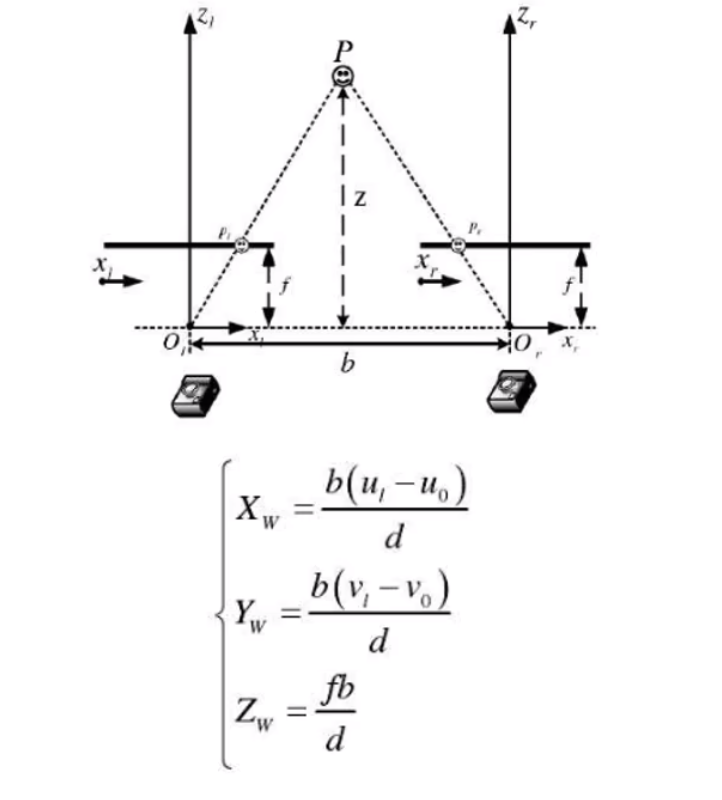
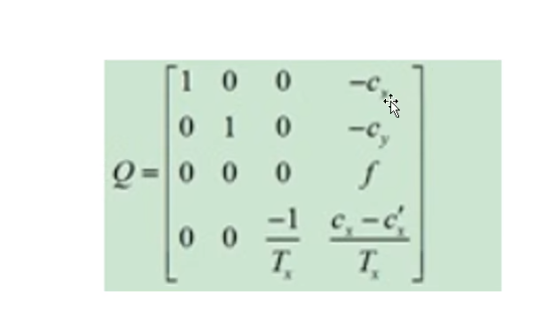